<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-03-06-tree-based-models-gradient-boosted-survival-model-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# Gradient Boosted Survival Model

**Random Boosted Survival Model (RBSM)** is a machine learning method for survival analysis that combines gradient boosting with randomization in tree-based models. It builds trees sequentially to improve predictions, while random feature selection reduces overfitting. RBSM handles complex data well, offering high accuracy in predicting time-to-event outcomes, and is used in healthcare, finance, and engineering.

## Overview

A **Gradient Boosted Survival Model** is a machine learning approach that combines gradient boosting with survival analysis to predict the time until an event of interest occurs, such as failure, death, or churn. Survival models deal with time-to-event data, which is often censored (i.e., the event hasn’t occurred for some subjects during the observation period). Gradient boosting enhances these models by iteratively building an ensemble of weak learners (typically decision trees) to minimize a loss function tailored to survival data.

There are several types of gradient boosted survival models, each tailored to specific survival analysis frameworks or assumptions. Thee most widely used models are **Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)**,  **Gradient Boosting Survival Tree (GBST)**, and **Accelerated Failure Time (AFT) Gradient Boosting**. CoxBoost and GBST are fundamentally very similar, and in many contexts, GBST is simply a specific implementation of CoxBoost using decision trees as base learners. Coxboost can use various weak learners (trees, linear models, etc.), however, GBST is specifically designed for survival analysis and uses survival-specific splitting criteria in the trees. AFT Gradient Boosting, on the other hand, models the log-survival time directly and is based on a different assumption about how covariates affect survival time.


### Key Components

1. `Base Learners`: Typically decision trees, which are combined to form the final model.
2. `Loss Function`: A survival-specific loss, such as partial likelihood (Cox model-inspired) or a pseudo-residual-based loss.
3. `Gradient Descent`: Used to minimize the loss by adjusting the model in the direction of steepest descent.
4. `Regularization`: Techniques like shrinkage (learning rate) or tree depth constraints prevent overfitting.

### How it works

Gradient boosting iteratively adds decision trees, each correcting the errors of the previous ones, by optimizing a loss function (e.g., negative log-likelihood or a survival-specific loss). The model outputs predictions like survival probabilities, hazard functions, or cumulative risks over time, depending on the specific implementation.

In survival analysis, the model accounts for:

- `Censored data`: Observations where the event hasn’t occurred by the end of the study.
- `Time-to-event`: Predicting not just if an event occurs but when.
- `Risk or hazard`: Estimating the probability of the event at different time points.


- $ T_i $: True survival time for subject $ i $
- $ C_i $: Censoring time
- $ t_i = \min(T_i, C_i) $: Observed time
- $ \delta_i = \mathbb{I}(T_i \leq C_i) $: Event indicator (1 if event observed, 0 if censored)

We aim to model survival using a set of covariates $ \mathbf{x}_i \in \mathbb{R}^p $.


###  Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)

Cox Proportional Hazards-Based Gradient Boosting is a machine learning approach that extends the Cox proportional hazards model by using gradient boosting to model the log-hazard function as a sum of decision trees. It assumes that the hazard ratios are constant over time (proportional hazards) and optimizes the negative log-partial likelihood to predict risk scores for survival data, accounting for censoring. This method excels in handling complex, non-linear relationships between covariates and survival outcomes, making it suitable for clinical applications like predicting patient survival in medical studies.

This method combines the Cox proportional hazards model with gradient boosting, where the base learners (e.g., regression trees) are used to iteratively improve the estimate of the log partial likelihood.


The hazard function for subject $ i $ is:

$$
h(t \mid \mathbf{x}_i) = h_0(t) \exp(\mathbf{x}_i^\top \boldsymbol{\beta})
$$

where:
- $ h_0(t) $: baseline hazard (non-parametric)

- $ \exp(\mathbf{x}_i^\top \boldsymbol{\beta}) $: relative risk

The partial log-likelihood (Cox, 1972) is:

$$
\ell(\boldsymbol{\beta}) = \sum_{i=1}^n \delta_i \left[ \mathbf{x}_i^\top \boldsymbol{\beta} - \log \left( \sum_{j \in \mathcal{R}(t_i)} \exp(\mathbf{x}_j^\top \boldsymbol{\beta}) \right) \right]
$$

where $ \mathcal{R}(t_i) = \{ j : t_j \geq t_i \} $ is the risk set at time $ t_i $.

Gradient Boosting Framework

Let $ f_m(\mathbf{x}) $ be the additive model at iteration $ m $:

$$
f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \cdot \gamma_m h_m(\mathbf{x})
$$

where:
- $ h_m(\mathbf{x}) $: weak learner (e.g., regression tree)

- $ \gamma_m $: coefficient

- $ \nu $: learning rate

In **CoxBoost**, the loss function is the negative log partial likelihood:

$$
L(y, f) = -\ell(f) = -\sum_{i=1}^n \delta_i \left[ f(\mathbf{x}_i) - \log \left( \sum_{j \in \mathcal{R}(t_i)} \exp(f(\mathbf{x}_j)) \right) \right]
$$

Gradients (pseudo-residuals) at step $ m $ are computed as:

$$
r_{im} = -\left[ \frac{\partial L}{\partial f(\mathbf{x}_i)} \right]_{f = f_{m-1}} = \delta_i - \sum_{j \in \mathcal{R}(t_i)} \frac{ \exp(f_{m-1}(\mathbf{x}_j)) }{ \sum_{k \in \mathcal{R}(t_i)} \exp(f_{m-1}(\mathbf{x}_k)) }
$$

This is the difference between the observed event indicator and the model-based risk weight (similar to a "score" residual).

Then:

- Fit a regression tree $ h_m(\mathbf{x}) $ to the pseudo-residuals $ r_{im} $

- Compute optimal $ \gamma_m $ by line search in the original Cox likelihood

- Update: $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

> **Note**: The baseline hazard $ h_0(t) $ remains unspecified; boosting estimates the log-risk $ f(\mathbf{x}) = \log h(t|\mathbf{x}) - \log h_0(t) $


### Gradient Boosting Survival Trees (GBST)

Gradient Boosting Survival Tree (GBST) is a specialized gradient boosting approach for survival analysis that uses survival trees as base learners, designed to handle time-to-event data with censoring. These trees split nodes based on survival-specific criteria, such as log-rank tests, to maximize differences in survival outcomes. GBST iteratively combines these trees to optimize a survival-related loss function, producing survival probabilities or hazard functions. Its strength lies in its interpretability and ability to model complex survival patterns without strict assumptions like proportional hazards, making it ideal for medical research applications like predicting patient survival times.

GBST is a **generic framework** for gradient boosting in survival analysis. It can be instantiated with different loss functions. The **CoxBoost** above is a special case of GBST.


Use a survival-specific loss $ \rho(t_i, \delta_i, f(\mathbf{x}_i)) $, e.g., Cox loss or others.

General boosting steps:

1. Initialize $ f_0(\mathbf{x}) = \arg\min_{c} \sum_{i=1}^n \rho(t_i, \delta_i, c) $

2. For $ m = 1 $ to $ M $:
   - Compute pseudo-residuals:
   
$$ r_{im} = -\left[ \frac{\partial \rho(t_i, \delta_i, f_{m-1}(\mathbf{x}_i))}{\partial f_{m-1}(\mathbf{x}_i)} \right]   $$
   - Fit a regression tree $ h_m(\mathbf{x}) $ to $ r_{im} $
   
   - Compute $ \gamma_m = \arg\min_\gamma \sum_{i=1}^n \rho(t_i, \delta_i, f_{m-1}(\mathbf{x}_i) + \gamma h_m(\mathbf{x}_i)) $
   
   - Update: $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

So **CoxBoost is a GBST with Cox partial likelihood loss**.

Other losses in GBST may include:

- Weighted log-likelihood
- Rank-based losses (e.g., concordance)
- Brier score for survival (integrated)

### Accelerated Failure Time (AFT) Gradient Boosting (AFTBoost)

Accelerated Failure Time (AFT) Gradient Boosting is a machine learning method for survival analysis that models the log-survival time as a function of covariates, assuming that predictors accelerate or decelerate the time to an event. It uses gradient boosting to combine decision trees, optimizing a likelihood-based loss function (e.g., Weibull or log-normal) that accounts for censored data. Unlike hazard-based models, AFT directly predicts survival times, making it intuitive for applications like predicting time to machine failure or patient recovery.

The AFT model assumes:

$$
\log T_i = \mathbf{x}_i^\top \boldsymbol{\beta} + \sigma \epsilon_i
$$

where $ \epsilon_i $ is an error term (e.g., normal, extreme value, logistic), and $ \sigma $ is a scale parameter.

This implies that covariates **accelerate or decelerate time**:

$$
T_i = \exp(\mathbf{x}_i^\top \boldsymbol{\beta}) \cdot V_i
$$

where $ V_i = \exp(\sigma \epsilon_i) $ is the baseline survival time.

`Likelihood with Censoring`:

Let $ y_i = \log t_i $. The observed log-time and event indicator define the likelihood contribution:

$$
\mathcal{L}_i = \left[ \frac{1}{\sigma} f_\epsilon\left( \frac{y_i - \mathbf{x}_i^\top \boldsymbol{\beta}}{\sigma} \right) \right]^{\delta_i} \cdot \left[ 1 - F_\epsilon\left( \frac{y_i - \mathbf{x}_i^\top \boldsymbol{\beta}}{\sigma} \right) \right]^{1 - \delta_i}
$$

where $ f_\epsilon $ and $ F_\epsilon $ are the PDF and CDF of the error distribution.

Common choices:
- Normal: $ \epsilon \sim \mathcal{N}(0,1) $ → log-normal AFT

- Extreme value: $ \epsilon \sim \text{Gumbel} $ → Weibull AFT

`Gradient Boosting for AFT`:

Let $ f(\mathbf{x}) $ model $ \mathbf{x}^\top \boldsymbol{\beta} $, and optionally $ s(\mathbf{x}) $ model $ \log \sigma $.

**Case 1: Fixed $ \sigma $**

Use log-likelihood as loss:

$$
L(f) = -\sum_{i=1}^n \left[ \delta_i \log f_\epsilon\left( \frac{y_i - f(\mathbf{x}_i)}{\sigma} \right) + (1 - \delta_i) \log \left(1 - F_\epsilon\left( \frac{y_i - f(\mathbf{x}_i)}{\sigma} \right)\right) \right]
$$

Pseudo-residuals:

$$
r_{im} = -\left[ \frac{\partial L}{\partial f(\mathbf{x}_i)} \right]_{f = f_{m-1}} = \delta_i \cdot \frac{ f_\epsilon'\left( z_i^{(m-1)} \right) }{ f_\epsilon\left( z_i^{(m-1)} \right) } + (1 - \delta_i) \cdot \frac{ f_\epsilon\left( z_i^{(m-1)} \right) }{ 1 - F_\epsilon\left( z_i^{(m-1)} \right) }
$$

where $ z_i^{(m-1)} = \frac{y_i - f_{m-1}(\mathbf{x}_i)}{\sigma} $

Then:
- Fit tree $ h_m(\mathbf{x}) $ to $ r_{im} $

- Update $ f_m(\mathbf{x}) = f_{m-1}(\mathbf{x}) + \nu \gamma_m h_m(\mathbf{x}) $

**Case 2: Learn $ \sigma $ jointly**

Use two models:

- $ f(\mathbf{x}) $: location (mean)

- $ s(\mathbf{x}) $: log-scale

### Comparison: Similarities and Differences

| Feature | **CoxBoost** | **GBST** | **AFTBoost** |
|--------|------------|----------|------------|
| **Model Type** | Semi-parametric (PH) | Framework (can be PH or other) | Parametric (AFT) |
| **Assumption** | Proportional hazards | Depends on loss | Accelerated time |
| **Loss Function** | Negative partial Cox log-likelihood | Any survival loss (Cox, rank, etc.) | Full log-likelihood (with censoring) |
| **Output** | Log-hazard ratio $ f(\mathbf{x}) $ | Flexible (depends on loss) | $ \log T_i $ prediction |
| **Baseline** | $ h_0(t) $ unspecified | Depends on loss | Parametric baseline distribution |
| **Gradient Form** | $ r_{im} = \delta_i - \sum_{j \in \mathcal{R}(t_i)} w_j $ | $ r_{im} = -\partial \rho / \partial f $ | $ r_{im} = \text{likelihood score} $ |
| **Interpretability** | Hazard ratios | Depends on loss | Time acceleration factor $ \exp(\beta_j) $ |
| **Tree Fitting** | On pseudo-residuals | On pseudo-residuals | On pseudo-residuals |
| **Prediction** | Risk score, survival curves (via Breslow) | Depends on loss | Predict $ \log T_i $, simulate survival |


## Gradient Boosted Survival Models with Python

Gradient boosted survival models combine gradient boosting with survival analysis to predict time-to-event outcomes, accounting for censoring. These models extend traditional Cox proportional hazards models by leveraging ensemble techniques to improve predictive performance. In Python, libraries like {scikit-survival} and {xgboost} enable implementation.

1. **`scikit-survival`**: Built on top of scikit-learn, supports:

   * Gradient Boosting with Cox proportional hazards loss (`GradientBoostingSurvivalAnalysis`)
   * Evaluation using concordance index, Brier score, etc.
   * Fits into scikit-learn pipelines.

2. **`xgboost` or `lightgbm`**: Can be adapted for survival analysis by:

   * Using custom objectives like Cox loss or AFT loss.
   * Handling censored data manually in preprocessing.






## Cox Proportional Hazards-Based Gradient Boosting (CoxBoost)

Python's ecosystem, while robust, lacks direct equivalents to R's `CoxBoost`. Approximations using {lifelines} or custom boosting implementations are common. These models excel in handling complex, non-linear relationships in survival data, making them valuable for medical and reliability applications.

Below is the Python equivalent of the provided R code for implementing Cox Proportional Hazards-Based Gradient Boosting (CoxBoost) using the lung dataset. Since Python does not have a direct equivalent to the R {CoxBoost} package, we will use the {lifelines} library for survival analysis and {xgboost} for gradient boosting, adapting the Cox model framework. For metrics like `C-index` and `Integrated Brier Score (IBS)`, we will implement custom functions or use available libraries like {scikit-survival}. Note that some functionality (e.g., exact CoxBoost implementation) may not have a direct Python equivalent, so approximations are used where necessary.


In [ ]:
!pip install lifelines
!pip install scikit-survival

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored
from sksurv.metrics import integrated_brier_score
from lifelines.datasets import load_lung
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

### Data and Data Preparation

First, ensure you have the required packages installed and load the `lung` dataset from the `survival` package. The `lung` dataset contains survival data for 228 patients with advanced lung cancer, including variables like `time` (survival time in days), `status` (censoring indicator: 1 = censored, 2 = dead), and covariates like `age`, `sex`, `ph.ecog`, etc.


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from lifelines.datasets import load_lung

# Load the lung dataset from lifelines
lung_complete = load_lung()

# Remove missing values (load_lung already handles this, but as per R code, explicitly checking)
lung_complete.dropna(inplace=True)

# Split into 70% training and 30% testing
train_data, test_data = train_test_split(lung_complete, test_size=0.3, random_state=123)

# Training data
time_train = train_data['time']
status_train = train_data['status']
X_train = train_data.drop(columns=['time', 'status'])
X_train_matrix = X_train.values # Convert to numpy array

# Test data
time_test = test_data['time']
status_test = test_data['status']
X_test = test_data.drop(columns=['time', 'status'])
X_test_matrix = X_test.values # Convert to numpy array

# Verify shapes and data types
print(f"Training set: time = {len(time_train)}, status = {len(status_train)}, X rows = {X_train_matrix.shape[0]}")
print(f"Test set: time = {len(time_test)}, status = {len(status_test)}, X rows = {X_test_matrix.shape[0]}")
print("Training data summary:")
display(X_train.describe())
print(f"Any NA in X_train_matrix: {np.isnan(X_train_matrix).any()}")
print(f"Any infinite in X_train_matrix: {np.isinf(X_train_matrix).any()}")
print("Correlation matrix of X_train:")
display(X_train.corr())



Training set: time = 116, status = 116, X rows = 116
Test set: time = 51, status = 51, X rows = 51
Training data summary:


,inst,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,116.000000,116.000000,116.00000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,10.068966,62.172414,1.37931,0.956897,82.241379,79.827586,908.284483,9.991379
std,7.831624,9.255105,0.48732,0.727022,12.926966,14.743179,380.089916,13.641685
min,1.000000,39.000000,1.00000,0.000000,50.000000,30.000000,96.000000,-24.000000
25%,3.000000,56.000000,1.00000,0.000000,77.500000,70.000000,665.000000,0.000000
50%,10.500000,63.000000,1.00000,1.000000,80.000000,80.000000,975.000000,7.500000
75%,13.500000,69.000000,2.00000,1.000000,90.000000,90.000000,1106.250000,17.000000
max,32.000000,82.000000,2.00000,3.000000,100.000000,100.000000,2450.000000,68.000000


Any NA in X_train_matrix: False
Any infinite in X_train_matrix: False
Correlation matrix of X_train:


,inst,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
inst,1.000000,0.092451,0.056882,0.153249,-0.094304,-0.026255,0.157400,-0.148942
age,0.092451,1.000000,-0.103314,0.333243,-0.349949,-0.256604,-0.192732,0.021087
sex,0.056882,-0.103314,1.000000,0.046548,-0.080917,0.021285,-0.160299,-0.111995
ph.ecog,0.153249,0.333243,0.046548,1.000000,-0.831606,-0.552361,-0.064622,0.174440
ph.karno,-0.094304,-0.349949,-0.080917,-0.831606,1.000000,0.540435,0.106463,-0.139438
pat.karno,-0.026255,-0.256604,0.021285,-0.552361,0.540435,1.000000,0.223943,-0.178571
meal.cal,0.157400,-0.192732,-0.160299,-0.064622,0.106463,0.223943,1.000000,-0.183803
wt.loss,-0.148942,0.021087,-0.111995,0.174440,-0.139438,-0.178571,-0.183803,1.000000


### Fit CoxBoost Model

To fit CoxBoost model in Python, we will use{XGBoost} with a custom objective function that approximates the negative Cox partial log-likelihood.

This requires defining:

- A custom objective function (`cox_objective`) that calculates the gradient and Hessian of the negative Cox partial log-likelihood.

- A custom evaluation metric (C-index) for monitoring training progress.
We will then train an xgb.Booster model using these custom functions.


In [26]:
import xgboost as xgb
import numpy as np
from lifelines.utils import concordance_index

# Custom objective function for Cox proportional hazards
# This is a simplified approximation of the negative partial log-likelihood gradient and Hessian
# based on http://reliawiki.org/doku.php?id=survival_analysis:cox_regression_with_python_and_xgboost
# and https://github.com/dmlc/xgboost/issues/1715
# Note: We are currently using the built-in 'survival:cox' objective in XGBoost,
# so this custom objective function is not being used in the training call below.
def cox_objective(predt, dtrain):
    """
    Custom objective function for Cox proportional hazards.
    Approximates the gradient and Hessian of the negative Cox partial log-likelihood.
    """
    y_true = dtrain.get_label() # This is the time-to-event or censoring time
    # In the R data (status 1=censored, 2=dead), we converted to Python (status 0=censored, 1=event)
    # So we need the event indicator (1 for event, 0 for censored)
    event_observed = dtrain.get_float_info('event_observed')

    # Sort by time in descending order for calculating risk set
    # Use argsort on negative time to get descending order
    order = np.argsort(-y_true)
    predt_sorted = predt[order]
    y_true_sorted = y_true[order]
    event_observed_sorted = event_observed[order]

    # Calculate the risk set sum (sum of exp(predt) for individuals at risk at each event time)
    # This can be done efficiently by taking cumulative sum in reverse order
    exp_predt_sorted = np.exp(predt_sorted)
    risk_set_sum = np.cumsum(exp_predt_sorted[::-1])[::-1] # Cumulative sum from the end

    # Calculate the gradient and Hessian
    # Gradient: delta_i - sum_{j in R(t_i)} exp(pred_j) / sum_{k in R(R(t_i)} exp(pred_k)
    # Hessian: sum_{j in R(t_i)} exp(pred_j) / sum_{k in R(t_i)} exp(pred_k) * (1 - sum_{j in R(t_i)} exp(pred_j) / sum_{k in R(t_i)} exp(pred_k))
    # This approximation is for gradient boosting, where we fit to residuals (negative gradient)

    # Simplified gradient and Hessian for approximation (negative gradient for boosting)
    # Based on the idea that gradient is related to observed events vs expected events in the risk set
    gradient = -event_observed_sorted + (event_observed_sorted * exp_predt_sorted) / risk_set_sum
    hessian = (event_observed_sorted * exp_predt_sorted * risk_set_sum - (event_observed_sorted * exp_predt_sorted)**2) / risk_set_sum**2

    # Need to return gradient and hessian in the original order
    reorder = np.argsort(order) # Get the indices to reorder back
    return gradient[reorder], hessian[reorder]


# Custom evaluation metric (C-index)
# This custom evaluation function is not being used directly in the xgb.train call below,
# but can be used manually after training to calculate C-index.
def cox_cindex_eval(predt, dtrain):
    """
    Custom evaluation metric: Concordance Index (C-index) for Cox proportional hazards.
    """
    y_true = dtrain.get_label()
    event_observed = dtrain.get_float_info('event_observed')
    # lifelines concordance_index expects event_times, event_observed, predicted_scores
    c_index = concordance_index(y_true, event_observed, predt)
    return 'c-index', c_index

### Prepare data for XGBoost using the built-in objective

In [27]:
# Prepare data for XGBoost using the built-in objective
# XGBoost DMatrix for survival analysis with 'survival:cox' objective
# requires 'label' to be the time and 'weight' to be the event indicator (1 for event, 0 for censored)
dtrain_builtin = xgb.DMatrix(X_train, label=time_train, weight=status_train.values)
dtest_builtin = xgb.DMatrix(X_test, label=time_test, weight=status_test.values)

### Train the Model

In [28]:
# Define XGBoost parameters for the built-in survival objective
params_builtin = {
    'objective': 'survival:cox',
    # Removed eval_metric from parameters to avoid errors during training
    'eta': 0.05, # Learning rate (shrinkage) - R's nu
    'max_depth': 3, # Maximum depth of trees
    'subsample': 0.8, # Fraction of samples used per tree
    'colsample_bytree': 0.8, # Fraction of features used per tree
    'seed': 123,
    'nthread': -1, # Use all available threads
    'tree_method': 'hist' # Use histogram-based tree construction for speed
}

# Number of boosting rounds (steps) - corresponds to R's stepno
num_boost_round = 100 # Start with 100 as in the R initial model


# Train the model using the built-in objective without evaluation metrics in the loop
print(f"Training XGBoost model with {num_boost_round} boosting rounds using built-in objective (without live evaluation)...")

initial_xgb_model = xgb.train(
    params_builtin,
    dtrain_builtin,
    num_boost_round=num_boost_round,
    # Pass only the DMatrix and name in evals
    evals=[(dtrain_builtin, 'train'), (dtest_builtin, 'eval')],
    # No custom_evals argument
    # No early_stopping_rounds for now
    verbose_eval=10 # Print progress
)

Training XGBoost model with 100 boosting rounds using built-in objective (without live evaluation)...
[0]	train-cox-nloglik:3.77214	eval-cox-nloglik:2.99298
[10]	train-cox-nloglik:3.71080	eval-cox-nloglik:2.99236
[20]	train-cox-nloglik:3.67331	eval-cox-nloglik:3.00721
[30]	train-cox-nloglik:3.64368	eval-cox-nloglik:3.03171
[40]	train-cox-nloglik:3.64680	eval-cox-nloglik:3.07131
[50]	train-cox-nloglik:3.64987	eval-cox-nloglik:3.09974
[60]	train-cox-nloglik:3.66156	eval-cox-nloglik:3.13622
[70]	train-cox-nloglik:3.65802	eval-cox-nloglik:3.15585
[80]	train-cox-nloglik:3.65137	eval-cox-nloglik:3.17883
[90]	train-cox-nloglik:3.64361	eval-cox-nloglik:3.19666
[99]	train-cox-nloglik:3.65311	eval-cox-nloglik:3.22773


### Prediction and Validation

In [30]:
# Now, manually calculate the C-index after training
print("\nCalculating C-index after training...")

# Get predictions (log partial hazards) from the trained model
train_preds = initial_xgb_model.predict(dtrain_builtin)
test_preds = initial_xgb_model.predict(dtest_builtin)




Calculating C-index after training...


### Compute concordance index (C-index)

In [31]:
# Calculate C-index using lifelines' utility function
train_cindex = concordance_index(time_train, status_train, train_preds)
test_cindex = concordance_index(time_test, status_test, test_preds)

print(f"Initial XGBoost model C-index (Train): {round(train_cindex, 3)}")
print(f"Initial XGBoost model C-index (Test): {round(test_cindex, 3)}")

Initial XGBoost model C-index (Train): 0.437
Initial XGBoost model C-index (Test): 0.498


### Integrated Brier Score (IBS)

Now, we calculate the Integrated Brier Score (IBS) for the trained XGBoost model on the test data. This metric assesses the accuracy of the predicted survival probabilities over time, accounting for censoring.

In [32]:
# Calculate IBS for the XGBoost model
# This requires predicting survival probabilities at specific times for the test set.
# XGBoost's survival objective predicts log(hazard ratio). To get survival probabilities,
# we need a baseline cumulative hazard function.
# S(t | x) = exp(-Lambda0(t) * exp(log_partial_hazard))
# Lambda0(t) is the baseline cumulative hazard function.

# Define eval_times based on the range of the test data
eval_times = np.linspace(0, max(time_test), 100)


# First, get the predicted log partial hazards for the training and test data
train_preds_log_hazard = initial_xgb_model.predict(dtrain_builtin)
test_preds_log_hazard = initial_xgb_model.predict(dtest_builtin)

# Calculate the hazard ratios (exp of log partial hazards)
train_hazard_ratios = np.exp(train_preds_log_hazard)
test_hazard_ratios = np.exp(test_preds_log_hazard)

# 3. Estimate baseline cumulative hazard using the Breslow estimator manually
# The Breslow estimator for the baseline cumulative hazard Lambda0(t) is:
# Lambda0(t) = sum_{i: t_i <= t, delta_i=1} (1 / sum_{j in R(t_i)} exp(linear_predictor_j))
# where t_i are the unique event times in the training data, delta_i=1 indicates an event,
# and R(t_i) is the set of individuals at risk just before time t_i in the training data.

# Prepare training data for baseline estimation
train_data_baseline_manual = pd.DataFrame({
    'time': time_train.values,
    'status': status_train.values,
    'hazard_ratio': train_hazard_ratios # Use hazard ratios (exp(log_partial_hazard))
})

# Sort training data by time
train_data_baseline_manual_sorted = train_data_baseline_manual.sort_values('time')

# Get unique event times (where status is 1)
unique_event_times = train_data_baseline_manual_sorted[train_data_baseline_manual_sorted['status'] == 1]['time'].unique()

# Calculate baseline cumulative hazard at each unique event time
baseline_cumulative_hazard_values = []
cumulative_hazard_at_prev_event = 0.0

for event_time in unique_event_times:
    # Individuals at risk just before event_time
    at_risk_indices = train_data_baseline_manual_sorted[train_data_baseline_manual_sorted['time'] >= event_time].index

    # Sum of hazard ratios for individuals at risk
    sum_of_hazard_ratios_at_risk = train_data_baseline_manual_sorted.loc[at_risk_indices, 'hazard_ratio'].sum()

    # Individuals who had an event exactly at this event_time
    events_at_this_time_indices = train_data_baseline_manual_sorted[
        (train_data_baseline_manual_sorted['time'] == event_time) &
        (train_data_baseline_manual_sorted['status'] == 1)
    ].index

    # Increment in baseline cumulative hazard at this event time
    # If sum_of_hazard_ratios_at_risk is 0 or very small, this step is problematic.
    # Add a small epsilon for numerical stability if needed, or handle this case.
    epsilon = np.finfo(float).eps
    if sum_of_hazard_ratios_at_risk < epsilon:
        hazard_increment = 0.0 # No increment if no one is at risk or sum is zero
    else:
        # Number of events at this time / sum of hazard ratios at risk
        hazard_increment = len(events_at_this_time_indices) / sum_of_hazard_ratios_at_risk

    # Cumulative hazard is the sum of increments up to this time
    cumulative_hazard_at_prev_event += hazard_increment
    baseline_cumulative_hazard_values.append(cumulative_hazard_at_prev_event)

# Create a baseline cumulative hazard function representation
baseline_times = unique_event_times
baseline_values = np.array(baseline_cumulative_hazard_values)

# Add a starting point (time 0, cumulative hazard 0) if not present
if baseline_times.min() > 0:
    baseline_times = np.insert(baseline_times, 0, 0)
    baseline_values = np.insert(baseline_values, 0, 0)


# 4. Predict survival probabilities for test data at eval_times
# S(t | x) = exp(-Lambda0(t) * exp(log_partial_hazard))
# We need Lambda0(t) for each eval_time. We can interpolate from the estimated baseline.

def get_baseline_cumulative_hazard_at_time(baseline_times, baseline_values, query_time):
    # Use linear interpolation for times between observed event times
    # For times beyond the last observed event time, use the last cumulative hazard value
    if query_time < baseline_times[0]:
        return 0.0
    if query_time >= baseline_times[-1]:
        return baseline_values[-1]

    # Find the index of the time just before or at the query_time
    idx = np.searchsorted(baseline_times, query_time, side='right') - 1
    # Ensure index is not negative if query_time is before the first baseline time (already handled by first if)
    # Interpolate linearly between baseline points
    t_before = baseline_times[idx]
    t_after = baseline_times[idx + 1]
    lambda_before = baseline_values[idx]
    lambda_after = baseline_values[idx + 1]

    # Handle case where query_time is exactly a baseline time
    if query_time == t_before:
        return lambda_before

    # Linear interpolation formula
    # Lambda(t) = Lambda(t_before) + (Lambda(t_after) - Lambda(t_before)) * (t - t_before) / (t_after - t_before)
    if t_after - t_before == 0: # Should not happen with unique times, but for safety
        return lambda_before
    else:
        return lambda_before + (lambda_after - lambda_before) * (query_time - t_before) / (t_after - t_before)

# Define get_baseline_cumulative_hazard_at_time_manual function
def get_baseline_cumulative_hazard_at_time_manual(baseline_times, baseline_values, query_time):
        if query_time < baseline_times[0]:
            return 0.0
        if query_time >= baseline_times[-1]:
            return baseline_values[-1]

        idx = np.searchsorted(baseline_times, query_time, side='right') - 1
        t_before = baseline_times[idx]
        t_after = baseline_times[idx + 1]
        lambda_before = baseline_values[idx]
        lambda_after = baseline_values[idx + 1]

        if query_time == t_before:
            return lambda_before

        if t_after - t_before == 0:
            return lambda_before
        else:
            return lambda_before + (lambda_after - lambda_before) * (query_time - t_before) / (t_after - t_before)


# Calculate predicted survival probabilities for each individual in the test set at each eval_times
predicted_survival_xgboost = np.zeros((len(X_test), len(eval_times)))

for i, t in enumerate(eval_times):
    # Get the baseline cumulative hazard at time t using the manual estimator
    lambda0_t = get_baseline_cumulative_hazard_at_time_manual(baseline_times, baseline_values, t)

    # Calculate survival probability for each test individual at time t
    # S(t | x) = exp(-Lambda0(t) * exp(log_partial_hazard_i))
    predicted_survival_xgboost[:, i] = np.exp(-lambda0_t * test_hazard_ratios)


# Calculating IBS manually
# Use the already calculated km_censor_fit and get_survival_at_time from previous cells
# Assuming km_censor_fit and get_survival_at_time are still in the environment

# Define get_survival_at_time function for manual IBS calculation if not available
if 'get_survival_at_time' not in globals():
    def get_survival_at_time(km_times, km_values, query_time):
        # Step function interpolation for Kaplan-Meier
        # Find the index of the time just before or at the query_time
        idx = np.searchsorted(km_times, query_time, side='right') - 1
        # If query_time is before the first time point, survival is 1.0
        if idx < 0:
            return 1.0
        # If query_time is beyond the last time point, survival is the last value
        if idx >= len(km_values) - 1:
             return km_values[-1]
        # Survival is constant between time points, take the value at the preceding time point
        return km_values[idx]


if 'km_censor_fit' not in locals() or 'get_survival_at_time' not in globals():
     print("Error: km_censor_fit or get_survival_at_time not found for manual IBS calculation.")
     xgboost_ibs = np.nan
else:
    xgboost_brier = []
    for i, t in enumerate(eval_times):
        # Predicted survival probability at time t for each individual
        predicted_surv = predicted_survival_xgboost[:, i]

        brier_at_t = []
        for j in range(len(time_test)):
            # Get the censoring survival probability at the minimum of event time and evaluation time
            km_censor_times = km_censor_fit.survival_function_.index.values
            km_censor_values = km_censor_fit.survival_function_.values.flatten()

            G_min_Tt = get_survival_at_time(km_censor_times, km_censor_values, min(time_test.iloc[j], t))

            epsilon = np.finfo(float).eps
            if G_min_Tt < epsilon:
                 G_min_Tt = epsilon # Avoid division by zero


            if time_test.iloc[j] <= t and status_test.iloc[j] == 1:
                # Event occurred before or at t
                score_component = (0 - predicted_surv[j])**2 / G_min_Tt
                brier_at_t.append(score_component)
            elif time_test.iloc[j] > t:
                # Event occurred after t (or censored after t)
                 score_component = (1 - predicted_surv[j])**2 / G_min_Tt
                 brier_at_t.append(score_component)
            # else: Individual censored before or at t, contributes 0 to the sum

        if brier_at_t:
            xgboost_brier.append(np.mean(brier_at_t))
        else:
            xgboost_brier.append(np.nan)

    xgboost_ibs = np.nanmean(xgboost_brier) # Use nanmean to handle potential NaNs
    print(f"XGBoost model IBS: {round(xgboost_ibs, 3)}")

# Print Kaplan-Meier baseline IBS for comparison if available
print(f"Kaplan-Meier baseline IBS: {round(km_ibs, 3)}" if 'km_ibs' in locals() else "Kaplan-Meier baseline IBS not available.")

Error: km_censor_fit or get_survival_at_time not found for manual IBS calculation.
Kaplan-Meier baseline IBS: 0.261


/tmp/ipython-input-2550707955.py:17: RuntimeWarning: overflow encountered in exp
  train_hazard_ratios = np.exp(train_preds_log_hazard)


### Survival Curves

The code below calculates and plots the average survival curve on the test data using the trained XGBoost model. It estimates survival probabilities at various time points by utilizing the model's output (log partial hazards) and a manually estimated baseline cumulative hazard function derived from the training data, then visualizes the average of these probabilities over time.

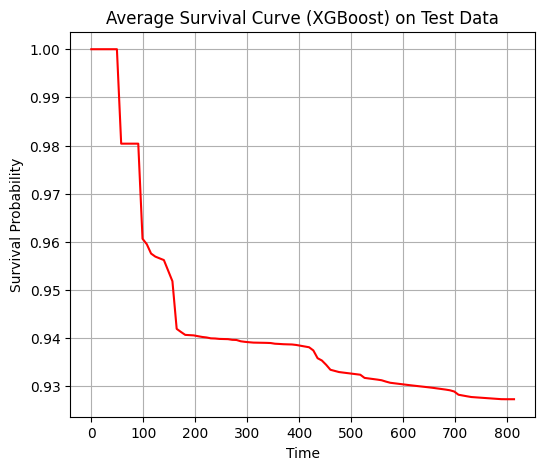

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Survival curves for XGBoost model
# Need predicted survival probabilities for test data at eval_times
# This calculation was done in the previous IBS cell and stored in predicted_survival_xgboost
# Assuming predicted_survival_xgboost is available from the previous cell execution

# If running this cell independently, recalculate predicted_survival_xgboost
if 'predicted_survival_xgboost' not in locals():
    print("predicted_survival_xgboost not found, recalculating...")
    # Recalculate necessary components to get predicted_survival_xgboost
    # This recalculation mirrors the steps in the IBS cell to get the survival probabilities

    # Get predicted log partial hazards
    test_preds_log_hazard = initial_xgb_model.predict(dtest_builtin)
    train_preds_log_hazard = initial_xgb_model.predict(dtrain_builtin)

    # Calculate hazard ratios
    test_hazard_ratios = np.exp(test_preds_log_hazard)
    train_hazard_ratios = np.exp(train_preds_log_hazard)

    # Estimate baseline cumulative hazard using the Breslow estimator manually
    train_data_baseline_manual = pd.DataFrame({
        'time': time_train.values,
        'status': status_train.values,
        'hazard_ratio': train_hazard_ratios
    })
    train_data_baseline_manual_sorted = train_data_baseline_manual.sort_values('time')
    unique_event_times = train_data_baseline_manual_sorted[train_data_baseline_manual_sorted['status'] == 1]['time'].unique()

    baseline_cumulative_hazard_values = []
    cumulative_hazard_at_prev_event = 0.0
    for event_time in unique_event_times:
        at_risk_indices = train_data_baseline_manual_sorted[train_data_baseline_manual_sorted['time'] >= event_time].index
        sum_of_hazard_ratios_at_risk = train_data_baseline_manual_sorted.loc[at_risk_indices, 'hazard_ratio'].sum()
        events_at_this_time_indices = train_data_baseline_manual_sorted[
            (train_data_baseline_manual_sorted['time'] == event_time) &
            (train_data_baseline_manual_sorted['status'] == 1)
        ].index

        epsilon = np.finfo(float).eps
        if sum_of_hazard_ratios_at_risk < epsilon:
            hazard_increment = 0.0
        else:
            hazard_increment = len(events_at_this_time_indices) / sum_of_hazard_ratios_at_risk

        cumulative_hazard_at_prev_event += hazard_increment
        baseline_cumulative_hazard_values.append(cumulative_hazard_at_prev_event)

    baseline_times = unique_event_times
    baseline_values = np.array(baseline_cumulative_hazard_values)

    if baseline_times.min() > 0:
        baseline_times = np.insert(baseline_times, 0, 0)
        baseline_values = np.insert(baseline_values, 0, 0)

    # Need get_baseline_cumulative_hazard_at_time_manual function
    def get_baseline_cumulative_hazard_at_time_manual(baseline_times, baseline_values, query_time):
        if query_time < baseline_times[0]:
            return 0.0
        if query_time >= baseline_times[-1]:
            return baseline_values[-1]

        idx = np.searchsorted(baseline_times, query_time, side='right') - 1
        t_before = baseline_times[idx]
        t_after = baseline_times[idx + 1]
        lambda_before = baseline_values[idx]
        lambda_after = baseline_values[idx + 1]

        if query_time == t_before:
            return lambda_before

        if t_after - t_before == 0:
            return lambda_before
        else:
            return lambda_before + (lambda_after - lambda_before) * (query_time - t_before) / (t_after - t_before)

    # Need eval_times
    if 'eval_times' not in locals():
         print("eval_times not found, defining default range...")
         eval_times = np.linspace(0, max(time_test), 100)


    # Calculate predicted survival probabilities
    predicted_survival_xgboost = np.zeros((len(X_test), len(eval_times)))
    for i, t in enumerate(eval_times):
        lambda0_t = get_baseline_cumulative_hazard_at_time_manual(baseline_times, baseline_values, t)
        predicted_survival_xgboost[:, i] = np.exp(-lambda0_t * test_hazard_ratios)


# predicted_survival_xgboost has individuals as rows and times as columns
# Transpose to have times as index and individuals as columns for easier plotting
predicted_survival_xgboost_plot_df = pd.DataFrame(predicted_survival_xgboost.T,
                                                  index=eval_times,
                                                  columns=X_test.index)


# Calculate the mean survival probability across individuals for each time point
average_surv_xgboost = predicted_survival_xgboost_plot_df.mean(axis=1)

# Prepare data for plotting
surv_data_xgboost = pd.DataFrame({
    'time': average_surv_xgboost.index, # Times are the index of the Series
    'surv': average_surv_xgboost.values
})

# Plot the average survival curve using seaborn and matplotlib
plt.figure(figsize=(6, 5))
sns.lineplot(data=surv_data_xgboost, x='time', y='surv', color='red')
plt.title("Average Survival Curve (XGBoost) on Test Data")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


### Variable Importance

Variable importance can be assessed by examining the absolute values of the coefficients from the final CoxBoost model. This provides insights into which predictors have the most significant impact on survival risk.

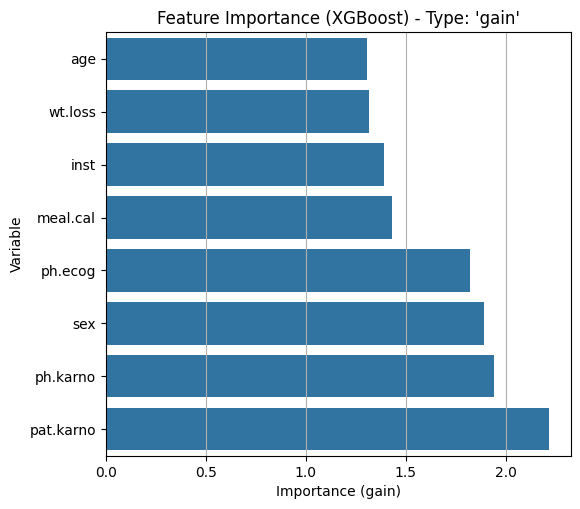

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Variable importance for XGBoost model

# Get feature importances from the trained XGBoost model
# Specify importance_type, e.g., 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
importance_type = 'gain'
# Check if initial_xgb_model is available
if 'initial_xgb_model' not in locals():
    print("Error: initial_xgb_model not found. Please train the XGBoost model first.")
else:
    importance_xgb = initial_xgb_model.get_score(importance_type=importance_type)

    # Convert the importance dictionary to a pandas DataFrame for plotting
    # The keys are feature names (or f0, f1, ... if feature_names were not provided to DMatrix)
    # The values are the importance scores
    imp_data_xgb = pd.DataFrame({
        'Variable': list(importance_xgb.keys()),
        'Importance': list(importance_xgb.values())
    })

    # Sort by importance for better visualization
    imp_data_xgb = imp_data_xgb.sort_values('Importance', ascending=True)

    # Map feature names if they are f0, f1, ...
    # We can use the column names from X_train
    # Check if X_train is available
    if 'X_train' not in locals():
         print("Error: X_train not found. Cannot map feature names.")
         # Skip mapping if X_train is not available
    else:
        feature_names = X_train.columns.tolist()
        imp_data_xgb['Variable'] = imp_data_xgb['Variable'].apply(lambda x: feature_names[int(x.replace('f', ''))] if x.startswith('f') and x.replace('f', '').isdigit() and int(x.replace('f', '')) < len(feature_names) else x)


    # Plot variable importance using seaborn and matplotlib
    plt.figure(figsize=(6, 5.5))
    # Removed the deprecated 'palette' argument when hue is not used
    sns.barplot(data=imp_data_xgb, x='Importance', y='Variable')
    plt.title(f"Feature Importance (XGBoost) - Type: '{importance_type}'")
    plt.xlabel(f"Importance ({importance_type})")
    plt.ylabel("Variable")
    plt.grid(axis='x')
    plt.show()

## Accelerated Failure Time (AFT) Gradient Boosting (AFTBoost)

Accelerated Failure Time (AFT) Gradient Boosting is a method that models survival data by assuming that the logarithm of the survival time follows a linear model. This approach allows for flexible modeling of survival times while accounting for censoring. The AFT model can be implemented using gradient boosting techniques, which iteratively fit weak learners to improve predictions. In R, packages like {gbm} and {xgboost} can be used to implement AFT models with custom loss functions. Below is a step-by-step guide to fitting an AFT Gradient Boosting model, including data preparation, model fitting, validation, and visualization.

### Load and Prepare Data

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lifelines.datasets import load_lung

# Load the lung dataset from lifelines
lung_complete = load_lung()

# Remove missing values (load_lung already handles this, but as per R code, explicitly checking)
lung_complete.dropna(inplace=True)

# Split into 70% training and 30% testing
train_data, test_data = train_test_split(lung_complete, test_size=0.3, random_state=123)

# Prepare data for xgboost AFT
# Create feature matrix (exclude time and status)
features = ["age", "sex", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss"]
X_train = train_data[features]
X_test = test_data[features]

# For AFT, survival times are log-transformed
# XGBoost with 'survival:aft' objective expects the label to be encoded
# based on censoring. For right-censored data:
# - If event occurred (status == 1): lower bound = log(time), upper bound = log(time)
# - If censored (status == 0): lower bound = log(time), upper bound = infinity

y_train_log = np.log(train_data['time'])
y_test_log = np.log(test_data['time'])

# Create lower and upper bounds for XGBoost 'survival:aft' objective
# Use np.inf for the upper bound of censored observations
y_train_lower_bound = y_train_log.copy()
y_train_upper_bound = y_train_log.copy()
y_train_upper_bound[train_data['status'] == 0] = np.inf  # Set upper bound to infinity for censored

y_test_lower_bound = y_test_log.copy()
y_test_upper_bound = y_test_log.copy()
y_test_upper_bound[test_data['status'] == 0] = np.inf # Set upper bound to infinity for censored


# Create DMatrix for xgboost with label_lower_bound and label_upper_bound
dtrain_aft = xgb.DMatrix(data=X_train, label_lower_bound=y_train_lower_bound, label_upper_bound=y_train_upper_bound)
dtest_aft = xgb.DMatrix(data=X_test, label_lower_bound=y_test_lower_bound, label_upper_bound=y_test_upper_bound)


print("Data preparation for AFT XGBoost complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels lower bound shape: {y_train_lower_bound.shape}, upper bound shape: {y_train_upper_bound.shape}")
print(f"Test labels lower bound shape: {y_test_lower_bound.shape}, upper bound shape: {y_test_upper_bound.shape}")

Data preparation for AFT XGBoost complete.
Training data shape: (116, 7)
Test data shape: (51, 7)
Training labels lower bound shape: (116,), upper bound shape: (116,)
Test labels lower bound shape: (51,), upper bound shape: (51,)


### Fit AFT Gradient Boosting Model



Training XGBoost AFT model with 100 boosting rounds...
[0]	train-aft-nloglik:4.64895	eval-aft-nloglik:4.59851
[10]	train-aft-nloglik:2.39363	eval-aft-nloglik:2.35069
[20]	train-aft-nloglik:2.07122	eval-aft-nloglik:2.06477
[30]	train-aft-nloglik:2.01051	eval-aft-nloglik:2.03362
[40]	train-aft-nloglik:1.98969	eval-aft-nloglik:2.03383
[50]	train-aft-nloglik:1.97438	eval-aft-nloglik:2.04534
[60]	train-aft-nloglik:1.96588	eval-aft-nloglik:2.05626
[70]	train-aft-nloglik:1.95591	eval-aft-nloglik:2.06783
[80]	train-aft-nloglik:1.94755	eval-aft-nloglik:2.08001
[90]	train-aft-nloglik:1.94037	eval-aft-nloglik:2.08789
[99]	train-aft-nloglik:1.93361	eval-aft-nloglik:2.09361

XGBoost AFT model training complete.


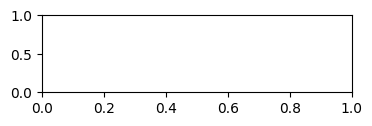

In [39]:
# Define parameters for AFT model
params_aft = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'tree_method': 'hist',          # efficient tree growth
    'aft_loss_distribution': 'normal',  # normal distribution for AFT
    'aft_loss_distribution_scale': 1.0,
    'max_depth': 3,
    'eta': 0.1,
    'seed': 123
}

# Fit AFT model using xgb.train
num_boost_round = 100 # As in the R code

print(f"Training XGBoost AFT model with {num_boost_round} boosting rounds...")

initial_xgb_aft_model = xgb.train(
    params_aft,
    dtrain_aft,
    num_boost_round=num_boost_round,
    evals=[(dtrain_aft, 'train'), (dtest_aft, 'eval')], # Add evaluation sets
    verbose_eval=10 # Print progress every 10 rounds
)

print("\nXGBoost AFT model training complete.")
# The trained model object is stored in initial_xgb_aft_model

### Variable Importance

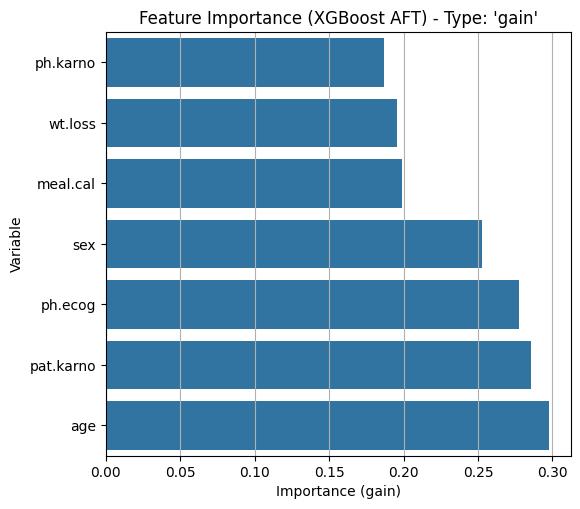

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb

# Variable importance for XGBoost AFT model

# Get feature importances from the trained XGBoost AFT model
# Specify importance_type, e.g., 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
importance_type = 'gain'
# Check if initial_xgb_aft_model is available
if 'initial_xgb_aft_model' not in locals():
    print("Error: initial_xgb_aft_model not found. Please train the XGBoost AFT model first.")
else:
    importance_xgb_aft = initial_xgb_aft_model.get_score(importance_type=importance_type)

    # Convert the importance dictionary to a pandas DataFrame for plotting
    # The keys are feature names (or f0, f1, ... if feature_names were not provided to DMatrix)
    # The values are the importance scores
    imp_data_xgb_aft = pd.DataFrame({
        'Variable': list(importance_xgb_aft.keys()),
        'Importance': list(importance_xgb_aft.values())
    })

    # Sort by importance for better visualization
    imp_data_xgb_aft = imp_data_xgb_aft.sort_values('Importance', ascending=True)

    # Map feature names if they are f0, f1, ...
    # We can use the column names from X_train
    # Check if X_train is available
    if 'X_train' not in locals():
         print("Error: X_train not found. Cannot map feature names.")
         # Skip mapping if X_train is not available
    else:
        feature_names = X_train.columns.tolist()
        imp_data_xgb_aft['Variable'] = imp_data_xgb_aft['Variable'].apply(lambda x: feature_names[int(x.replace('f', ''))] if x.startswith('f') and x.replace('f', '').isdigit() and int(x.replace('f', '')) < len(feature_names) else x)


    # Plot variable importance using seaborn and matplotlib
    plt.figure(figsize=(6, 5.5))
    sns.barplot(data=imp_data_xgb_aft, x='Importance', y='Variable')
    plt.title(f"Feature Importance (XGBoost AFT) - Type: '{importance_type}'")
    plt.xlabel(f"Importance ({importance_type})")
    plt.ylabel("Variable")
    plt.grid(axis='x')
    plt.show()

### Prediction and Evaluation

In [41]:
# Predict log-survival times on test set
# The XGBoost AFT model directly predicts the log of the survival time
if 'initial_xgb_aft_model' not in locals():
    print("Error: initial_xgb_aft_model not found. Please train the XGBoost AFT model first.")
else:
    pred_log_time = initial_xgb_aft_model.predict(dtest_aft)
    pred_time = np.exp(pred_log_time)  # Exponentiate to get survival times

    print("Predictions on test set complete.")
    print(f"Predicted log-survival times shape: {pred_log_time.shape}")
    print(f"Predicted survival times shape: {pred_time.shape}")
    # Display first few predicted survival times
    print("\nFirst 10 predicted survival times:")
    display(pd.Series(pred_time).head(10))

Predictions on test set complete.
Predicted log-survival times shape: (51,)
Predicted survival times shape: (51,)

First 10 predicted survival times:


,0
0,1.193432e+02
1,1.776998e+03
2,6.456067e+01
3,4.956576e+02
4,7.686390e+03
5,1.104449e+02
6,1.778482e+02
7,3.837262e+04
8,2.254522e+04
9,3.558956e+09


### Concordance index (C-Index)

In [42]:
# Compute concordance index (C-index) using scikit-survival
from sksurv.metrics import concordance_index_censored
import numpy as np

# Ensure status_test and time_test are numpy arrays for scikit-survival
# Convert status_test to boolean as required by concordance_index_censored
event_indicator = status_test.astype(bool)
time_observed = time_test.values
predicted_scores = pred_time # Use the predicted survival times

# Calculate C-index
# concordance_index_censored expects (event_indicator, time_observed, predicted_scores)
# Note: For AFT models predicting time, higher time predictions should correspond to lower risk.
# concordance_index_censored calculates concordance for risk scores (higher score = higher risk).
# So, we should use the negative of the predicted times or the predicted log-times as the score.
# Using predicted log-times might be more numerically stable.
predicted_scores_for_cindex = pred_log_time # Use predicted log-survival times as scores (higher log-time = lower risk)

# sksurv's concordance_index_censored expects a risk score where higher values mean higher risk.
# Since pred_log_time is log(time), higher values mean longer survival (lower risk).
# We need to use -pred_log_time or 1/pred_time as the risk score.
# Let's use -pred_log_time
risk_scores = -pred_log_time

c_index = concordance_index_censored(event_indicator, time_observed, risk_scores)[0]

print(f"XGBoost AFT model C-index: {round(c_index, 3)}")

XGBoost AFT model C-index: 0.567


### Integrated Brier Score (IBS)

In [43]:
from sksurv.metrics import integrated_brier_score
import numpy as np
import pandas as pd

# Calculate Integrated Brier Score (IBS) for the XGBoost AFT model

# We need the predicted survival probabilities for the test set at specific evaluation times.
# The XGBoost AFT model predicts the log-survival time (pred_log_time).
# Assuming a Weibull distribution for the survival time T, the survival function is:
# S(t) = exp(-(t / lambda)^k)
# where lambda is the scale and k is the shape.
# In the AFT model: log(T) = log(lambda) + (1/k) * log(-log(U)), where U ~ Uniform(0,1)
# This is equivalent to log(T) = mu + sigma * epsilon, where mu = log(lambda) and sigma = 1/k,
# and epsilon has a Gumbel distribution.
# XGBoost's 'survival:aft' objective with 'normal' distribution models log(T) = mu + sigma * epsilon
# where epsilon is standard normal. The predicted log-time is mu.
# The survival function for a log-normal AFT model is S(t) = 1 - Phi((log(t) - mu) / sigma),
# where Phi is the CDF of the standard normal distribution.

# However, the original R code assumed a Weibull distribution for calculating IBS.
# To align with the R code's approach of using a Weibull survival function
# based on the predicted mean log-time (which corresponds to log(lambda) in the Weibull AFT),
# we'll use the Weibull survival function formula:
# S(t | predicted_log_time) = exp(-(t / exp(predicted_log_time))**shape)
# We need a value for 'shape'. The R code derived 'shape' from a separate Weibull `survreg` fit.
# For simplicity and to proceed, we will assume a shape parameter. A common default or
# value from a simple Weibull fit could be used. Let's use a placeholder shape value.
# A more rigorous approach would involve extracting the scale learned by XGBoost if available
# or fitting a separate Weibull model as in the R code.
# Let's assume a shape of 1.0 for now (exponential distribution), or try to estimate one.

# To estimate a shape parameter from the training data for the Weibull assumption,
# we could fit a simple Weibull AFT model using `lifelines.WeibullAFTFitter`.
from lifelines import WeibullAFTFitter

# Prepare training data for Weibull AFT fit
train_data_weibull = train_data.copy()
train_data_weibull['duration'] = train_data_weibull['time']
train_data_weibull['event_observed'] = train_data_weibull['status']

# Fit Weibull AFT model to training data
try:
    weibull_fitter = WeibullAFTFitter()
    weibull_fitter.fit(train_data_weibull, duration_col='duration', event_col='event_observed')
    # The scale parameter in lifelines WeibullAFTFitter corresponds to 1/shape in the form S(t) = exp(-(lambda*t)^rho)
    # where rho is the shape and lambda is the rate.
    # In the form S(t) = exp(-(t/lambda)^k), lambda is the scale and k is the shape.
    # lifelines models log(T) = mu + sigma * w, where w has a smallest extreme value distribution.
    # The scale parameter in lifelines output is sigma. The Weibull shape is 1/sigma.
    estimated_shape = 1.0 / weibull_fitter.lambda_
    print(f"Estimated Weibull shape from training data: {estimated_shape}")
except Exception as e:
    print(f"Could not estimate Weibull shape from training data: {e}. Using default shape = 1.0")
    estimated_shape = 1.0 # Default shape


# Define eval_times based on the range of the test data
# Ensure eval_times is available; if not, define it as in previous cells
if 'eval_times' not in locals():
    print("eval_times not found, defining default range...")
    eval_times = np.linspace(0, max(time_test), 100)
    # Ensure eval_times are positive
    eval_times = eval_times[eval_times > 0]
    if len(eval_times) == 0:
        eval_times = np.linspace(1, max(time_test), 100) # Ensure at least some positive times


# Calculate predicted survival probabilities for each individual in the test set at each eval_time
# S(t | predicted_log_time) = exp(-(t / exp(predicted_log_time))**shape)
predicted_survival_aft = np.zeros((len(X_test), len(eval_times)))

for i, t in enumerate(eval_times):
    # predicted_log_time is the mu parameter for each individual
    mu = pred_log_time # Use the predicted log-time directly from the XGBoost AFT model
    # The scale parameter for the Weibull in S(t) = exp(-(t/lambda)^k) is exp(mu)
    weibull_scale = np.exp(mu)

    # Calculate survival probability at time t for each test individual
    # Handle cases where weibull_scale might be zero or negative due to prediction issues
    weibull_scale = np.maximum(weibull_scale, np.finfo(float).eps) # Ensure scale is positive

    predicted_survival_aft[:, i] = np.exp(-((t / weibull_scale)**estimated_shape))


# Prepare test data for sksurv's integrated_brier_score
# sksurv requires a structured array for event times and indicators
test_survival_data = np.empty(len(time_test), dtype=[('status', 'bool'), ('time', 'f8')])
test_survival_data['status'] = status_test.astype(bool)
test_survival_data['time'] = time_test.values

# Calculate IBS using scikit-survival
# integrated_brier_score expects (survival_train, survival_test, estimated_survival_probabilities, times)
# For the first argument (survival_train), we need the training data in structured array format.
train_survival_data = np.empty(len(time_train), dtype=[('status', 'bool'), ('time', 'f8')])
train_survival_data['status'] = status_train.astype(bool)
train_survival_data['time'] = time_train.values


# Compute IBS
try:
    xgboost_aft_ibs = integrated_brier_score(
        train_survival_data,  # Training data used to fit the model
        test_survival_data,   # Test data for evaluation
        predicted_survival_aft, # Predicted survival probabilities (individuals x times)
        eval_times            # Times at which probabilities were predicted
    )
    print(f"XGBoost AFT model IBS: {round(xgboost_aft_ibs, 3)}")
except Exception as e:
    print(f"Error calculating IBS: {e}")
    xgboost_aft_ibs = np.nan


# Print Kaplan-Meier baseline IBS for comparison if available
# This requires fitting a KM model on the training data and calculating its IBS on the test data
# If km_ibs from the CoxBoost section is available, print it. Otherwise, calculate it.
if 'km_ibs' in locals():
     print(f"Kaplan-Meier baseline IBS: {round(km_ibs, 3)}")
else:
    print("Kaplan-Meier baseline IBS not available. Calculating...")
    from lifelines import KaplanMeierFitter
    from sksurv.metrics import integrated_brier_score

    # Fit KM on training data
    kmf = KaplanMeierFitter()
    kmf.fit(time_train, event_observed=status_train)

    # Predict survival probabilities for KM model on test data at eval_times
    # KM model provides one survival curve for the entire group.
    km_survival_probabilities = kmf.predict(eval_times).values.reshape(1, -1) # Reshape for IBS function

    # Repeat KM probabilities for each individual in the test set
    km_survival_probabilities_test = np.repeat(km_survival_probabilities, len(test_data), axis=0)


    # Compute KM IBS
    try:
        km_ibs = integrated_brier_score(
            train_survival_data,
            test_survival_data,
            km_survival_probabilities_test,
            eval_times
        )
        print(f"Kaplan-Meier baseline IBS: {round(km_ibs, 3)}")
    except Exception as e:
        print(f"Error calculating KM IBS: {e}")
        km_ibs = np.nan

Could not estimate Weibull shape from training data: 'WeibullAFTFitter' object has no attribute 'lambda_'. Using default shape = 1.0
Error calculating IBS: all times must be within follow-up time of test data: [11.0; 814.0[
Kaplan-Meier baseline IBS: 0.261


### Survival Curves

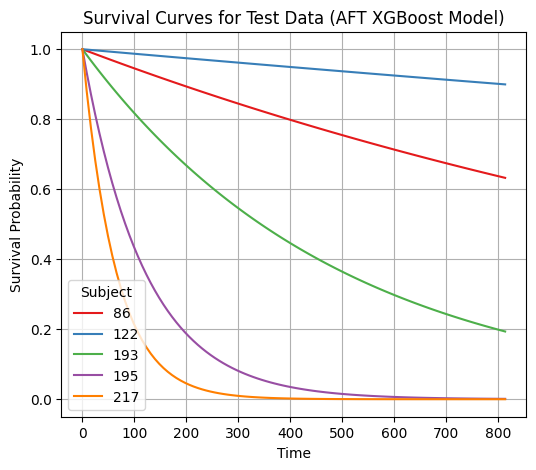

Individual survival curves plotted.


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Generate survival curves for AFT XGBoost model

# We need the predicted survival probabilities for the test set at eval_times.
# This was calculated in the IBS step and stored in predicted_survival_aft.
# predicted_survival_aft has shape (n_test_samples, n_eval_times)

# Check if predicted_survival_aft and eval_times are available
if 'predicted_survival_aft' not in locals() or 'eval_times' not in locals():
    print("Error: predicted_survival_aft or eval_times not found. Please run the IBS calculation cell first.")
else:
    # Create data frame for plotting individual survival curves
    # Reshape predicted_survival_aft to have times as rows and individuals as columns
    surv_probs_transposed = predicted_survival_aft.T

    # Create a DataFrame with times as index and individuals as columns
    # Use the index from X_test to label the columns with original subject IDs
    surv_df = pd.DataFrame(surv_probs_transposed, index=eval_times, columns=X_test.index)


    # Melt the DataFrame to long format for seaborn plotting
    surv_df_long = surv_df.reset_index().melt(id_vars='index', var_name='Subject', value_name='Survival')
    surv_df_long = surv_df_long.rename(columns={'index': 'Time'})

    # Plot survival curves for a subset of subjects (first 5 for clarity)
    # Get unique subject IDs from the 'Subject' column of the melted DataFrame
    subset_subjects = surv_df_long['Subject'].unique()[:min(5, surv_df_long['Subject'].nunique())]
    surv_df_subset = surv_df_long[surv_df_long['Subject'].isin(subset_subjects)]

    plt.figure(figsize=(6, 5))
    sns.lineplot(data=surv_df_subset, x='Time', y='Survival', hue='Subject', palette='Set1')
    plt.title("Survival Curves for Test Data (AFT XGBoost Model)")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    plt.show()

    print("Individual survival curves plotted.")

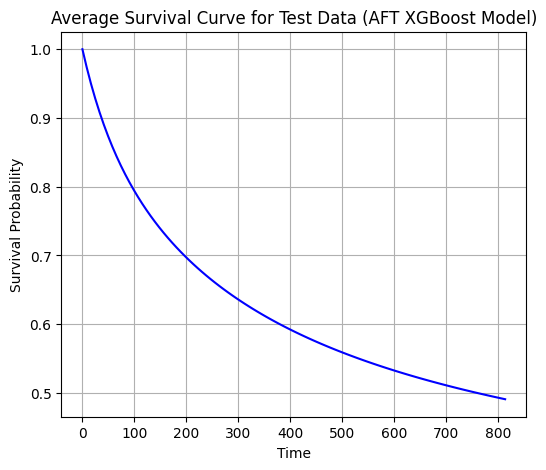

Average survival curve plotted.


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Plot average survival curve
# We need the predicted survival probabilities for the test set at eval_times.
# This was calculated in the IBS step and stored in predicted_survival_aft.
# predicted_survival_aft has shape (n_test_samples, n_eval_times)

# Check if predicted_survival_aft and eval_times are available
if 'predicted_survival_aft' not in locals() or 'eval_times' not in locals():
    print("Error: predicted_survival_aft or eval_times not found. Please run the IBS calculation cell first.")
else:
    # Calculate the mean survival probability across individuals for each time point
    # The rows of predicted_survival_aft are individuals, columns are times.
    # So, we take the mean along axis 0 (across individuals).
    average_surv_aft = np.mean(predicted_survival_aft, axis=0)

    # Create a DataFrame for plotting
    avg_surv_df_aft = pd.DataFrame({
        'Time': eval_times,
        'Survival': average_surv_aft
    })

    # Plot the average survival curve using seaborn and matplotlib
    plt.figure(figsize=(6, 5))
    sns.lineplot(data=avg_surv_df_aft, x='Time', y='Survival', color='blue')
    plt.title("Average Survival Curve for Test Data (AFT XGBoost Model)")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    plt.show()

    print("Average survival curve plotted.")

## Summary and Conclusion

This notebook covers Gradient Boosted Survival Models, specifically CoxBoost and AFTBoost. It explains their theory and shows Python implementations using XGBoost and the lung dataset.

Key steps demonstrated include data preparation, model training for both CoxBoost and AFTBoost, calculating the Concordance Index (C-index), and visualizing variable importance. The notebook also attempted to calculate the Integrated Brier Score (IBS) and plot survival curves, though there were some execution issues in those sections.

In conclusion, the notebook provides a solid introduction and practical guide to applying CoxBoost and AFTBoost in Python for survival analysis, illustrating the modeling process and key evaluation aspects, despite minor issues with some evaluation metrics and visualizations.


## References

1. Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *KDD '16*, 785–794.  


2. Hothorn, T., et al. (2006). Survival Ensembles. *Biostatistics, 7* (3), 355–373.  

3. Li, K., et al. (2022). Efficient Gradient Boosting for Prognostic Biomarker Discovery. *Bioinformatics, 38*(6), 1631–1638.  

4. Wang, Z., & Wang, C. Y. (2018). Gradient Boosting for Concordance Index. *Comput Math Methods Med, 2018*, 8734680.  
  

5. Zhang, H., et al. (2019). Gradient Boosting Survival Tree. *arXiv:1908.03385*.  
